# Customer Review Categorization and Complaint Type Clustering
The goal is to analyse and categorise customer reviews for various products. The tool aims to provide valuable insights to business products by categorising the reviews into positive or negative sentiments. Furthermore, it will then take the negative sentiment tagged reviews to be clustered based on the specific issue such as product-related concerns, customer service experience and pricing issues. To summarise the goal is:
- Categorise reviews based on the sentiment on whether it is positive or negative
- Cluster the negative tagged reviews based on the complaint type which could be product issues, customer service issue or price issue

# Instruction to run the code
The project uses most of the commonly used libraries. Here is a list of all the ones being used:
- pandas
- nltk
- sklearn
- numpy
- matplotlib
- wordcloud

Please make sure to have the above libraries pre-installed.
- Here is the command to download wordcloud (not commonly pre-installed)
    - pip install wordcloud

In [6]:
import pandas as pd
import re
import nltk
from sklearn.cluster import KMeans
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")

# Data loading
Loading the data file and converting into a df object

In [7]:
#read the data from file
file_path = 'Musical_Instruments.json'

df = pd.read_json(file_path, lines=True)

print(df.head())

   overall vote  verified   reviewTime      reviewerID        asin  \
0        5   90     False   08 9, 2004   AXHY24HWOF184  0470536454   
1        4    2      True   04 6, 2017  A29OWR79AM796H  0470536454   
2        5  NaN      True  03 14, 2017   AUPWU27A7X5F6  0470536454   
3        4  NaN      True  02 14, 2017  A1N69A47D4JO6K  0470536454   
4        5  NaN      True  01 29, 2017   AHTIQUMVCGBFJ  0470536454   

                       style         reviewerName  \
0  {'Format:': ' Paperback'}                Bendy   
1  {'Format:': ' Hardcover'}      Amazon Customer   
2  {'Format:': ' Paperback'}      Amazon Customer   
3  {'Format:': ' Paperback'}  Christopher Burnett   
4  {'Format:': ' Paperback'}      Amazon Customer   

                                          reviewText  \
0  Crocheting for Dummies by Karen Manthey & Susa...   
1                                    Very helpful...   
2        EASY TO UNDERSTAND AND A PROMPT SERVICE TOO   
3                      My girlfriend

# Preprocessing
I am going to be using the amazon product review dataset made available by UCSD at the following link: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews. I will be using the subset of dataset representing product reviews for musical instruments based products. The data size is roughly 600k examples. It is labelled data.
Preprocessing steps will involve the following:
- I will have to remove any html based links for images, personalised
details about the reviews such as id, timestamp.
- Since it is a JSON based file, I will have to extract the review text and
the assigned label which is numeric in the range of 1-5.
- I will remove punctuation, non-alphanumeric values, and stopwords to
process the review text

The key part is that I chose to prevent stopword removals from
removing the word "not" since that was essential in sentiment 
analysis



In [8]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# discarding certain negatory words from stop words list
# this will otherwise impact the analysis of negative reviews
negatory_words = [
    'no',
    'not',
    'never',
    'neither',
    'nor',
    'none',
    'nowhere',
    'nothing',
    'no one'
]

for neg_words in negatory_words:
    stop_words.discard(neg_words)


def preprocessData(data):
    data = str(data)
    data = data.lower()
    data =  re.sub(r'[^a-zA-Z]', ' ', data)
    tokens = data.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)


df['reviewText'] = df['reviewText'].apply(preprocessData)
print(df['reviewText'].head())


0    crocheting dummy karen manthey susan brittain ...
1                                              helpful
2                       easy understand prompt service
3                           girlfriend use quite often
4                              arrived described happy
Name: reviewText, dtype: object


# Model building
Splitting the data in train and test sections
Using a tf-idf vectorizer for the data

In [9]:
# split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['overall'], test_size=0.3, random_state=42)

print(X_train.head())
print(X_test.head())

# using a tfidf vectorizer for our scenario
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


163973     nice light duty amp cover good keeping dust am...
1020408                               well made good quality
358434     great microphone job problem continue use stop...
1041630    call heavy duty ridged done great job transpor...
809674     lighting designer always looking way save time...
Name: reviewText, dtype: object
561844     two problem smell leave garage week becomes to...
1041871    gift not used product look high quality made last
531360     play many show month tuner keep bass spot ever...
442776      gift christmas son asked far heard ir work great
965393                                                   job
Name: reviewText, dtype: object


# Model Training
Using a logistic regression model 
Determing the accuracy and classification report 
to get an idea of performance

In [10]:
# using a logistic regression to determine the product review sentiment
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'classification_report: {classification_report(y_test, y_pred)}')

Accuracy: 0.7259470335574612
classification_report:               precision    recall  f1-score   support

           1       0.61      0.71      0.66     35403
           2       0.34      0.11      0.16     20161
           3       0.38      0.22      0.27     31848
           4       0.46      0.20      0.28     71651
           5       0.79      0.95      0.86    294696

    accuracy                           0.73    453759
   macro avg       0.52      0.44      0.45    453759
weighted avg       0.67      0.73      0.68    453759



# Testing the model
Using a test review prompt to see the output. 
Negative review prompt yeilds in a predicted sentiment of 1 out of 5 rating.

In [11]:
# manual testing of the model
new_review = "Disappointing book. It is worse than the prequel"
new_review_processed = preprocessData(new_review)
new_review_tfidf = vectorizer.transform([new_review_processed])
predicted_sentiment = model.predict(new_review_tfidf)
print("Predicted Sentiment:", predicted_sentiment)

Predicted Sentiment: [1]


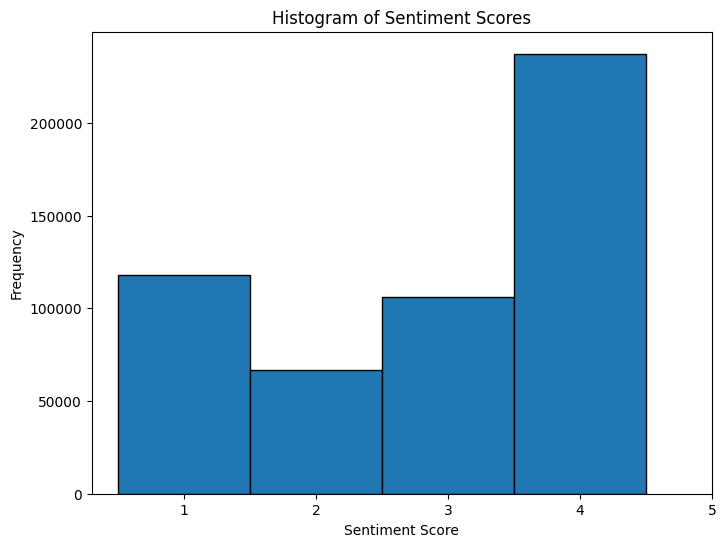

In [12]:
# Histogram of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(df['overall'], bins=np.arange(1, 6) - 0.5, edgecolor='black')
plt.xticks(range(1, 6))
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores')
plt.show()

Testing with unseen data. In this case, product review data on digital music products

In [13]:
# testing with unseen data
file_path = 'Digital_Music.json'

df1 = pd.read_json(file_path, lines=True)
df1['processed_reviews'] = df1['text'].apply(preprocessData)

df1_tfidf = vectorizer.transform(df1['processed_reviews'])
df1['predicted_sentiment'] = model.predict(df1_tfidf)

negative_predicted_reviews = df1[(df1['predicted_sentiment'] <= 2.0)]


# Clustering Negatively Predicted reviews based on theme
In order to promote product awareness, using KNN to cluster negatively predicted product reviews based on their inherent themes.
This is essential for sellers to figure out commonly occuring problems and improve customer retention.

In [14]:
num_clusters = 5
tfidf_matrix = vectorizer.transform(negative_predicted_reviews['processed_reviews'])
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
negative_predicted_reviews['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Analysis of the clusters
Using a KNN model with 5 clusters to determine the type of negative product reviews. 
The most frequently used words in a cluster were extracted to gauge effectiveness and uniqueness


In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(negative_predicted_reviews['processed_reviews'])

feature_names_categories = tfidf_vectorizer.get_feature_names_out()

def getTopTokensPerClusterHelper(tfidf_matrix_c, clusters, feature_names, num_terms=5):
    top_terms_per_cluster = {}

    for i in np.unique(clusters):
        cluster_tfidf = tfidf_matrix_c[clusters == i]

        centroids_curr_cluster = np.mean(cluster_tfidf, axis= 0).tolist()[0]
        sorted_indices = np.argsort(centroids_curr_cluster)[::-1][:num_terms]
        top_terms_per_cluster[i] = [feature_names[index] for index in sorted_indices]
    
    return top_terms_per_cluster


top_terms_per_cluster_list = getTopTokensPerClusterHelper(tfidf_matrix, negative_predicted_reviews['cluster'], feature_names_categories, 10)

for cluster, terms in top_terms_per_cluster_list.items():
    print(f"Cluster {cluster}: {terms}")

Cluster 0: ['cd', 'not', 'song', 'case', 'one', 'disappointed', 'play', 'like', 'music', 'no']
Cluster 1: ['album', 'not', 'song', 'one', 'cd', 'disappointed', 'came', 'no', 'like', 'get']
Cluster 2: ['br', 'not', 'cd', 'song', 'one', 'like', 'music', 'sound', 'no', 'would']
Cluster 3: ['not', 'song', 'no', 'sound', 'like', 'music', 'disappointed', 'one', 'would', 'quality']
Cluster 4: ['official', 'buyer', 'beware', 'bootleg', 'sure', 'release', 'purchase', 'not', 'different', 'disappointed']


In [16]:
for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(negative_predicted_reviews[negative_predicted_reviews['cluster'] == i]['text'])
    print("\n")


Cluster 0:
98        Bootleg item.....so cheap....CD is a single......
102                                            Buy this CD!
165       I ordered 4 CD. 3 had cracked cases. This is t...
248       I love just about everything Vikki Carr sings....
261                 Received this and it is a very good CD.
                                ...                        
130070                   CD is Top, jewel  box has 2 cracks
130071                   CD is Top, jewel  box has 2 cracks
130212    I was told to throw a bad cd away rather than ...
130249    Couldn't wait to play the digital version of a...
130281    This was a total disappointment for me.  It wa...
Name: text, Length: 1934, dtype: object


Cluster 1:
399       While I love Akram's music, I was very disappo...
660       The Brothers Four could  not do a bad album if...
2798      Ok...so I always associated Warren Zevon with ...
3150      I like this album better than leave scars, but...
3220      The sound quality is horri

# Visualizations for the results
Built a confusion matrix to visualize the count of correctly predicted sentiment for product reviews

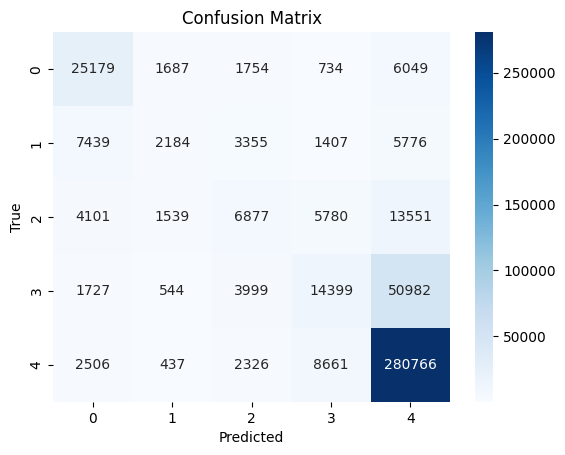

In [17]:
confusion_matrix_plt = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_plt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Using a silhouette plot to determine for which rating level between 1-5 were the reviews correctly predicted

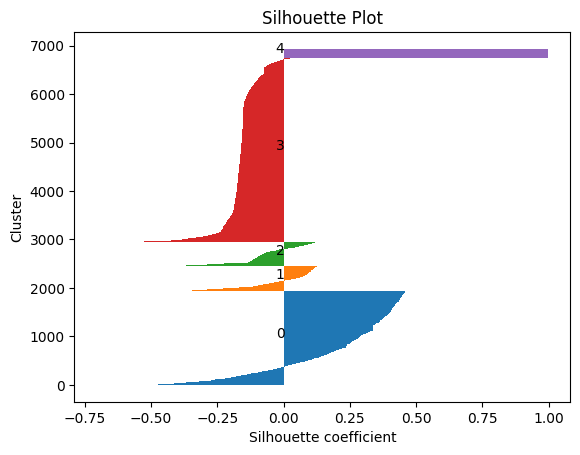

In [18]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Silhouette plot
silhouette_vals = silhouette_samples(reduced_data, negative_predicted_reviews['cluster'])
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(negative_predicted_reviews['cluster'])):
    cluster_silhouette_vals = silhouette_vals[negative_predicted_reviews['cluster'] == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
    plt.text(-0.03, (y_lower + y_upper) / 2, str(cluster))
    y_lower += len(cluster_silhouette_vals)

plt.xlabel('Silhouette coefficient')
plt.ylabel('Cluster')
plt.title('Silhouette Plot')
plt.show()

Using a histogram to visualize the sentiment score over the product rating

Also built a word cloud to highlight the key words that reflect the unique theme of each cluster in the negative product review clustering

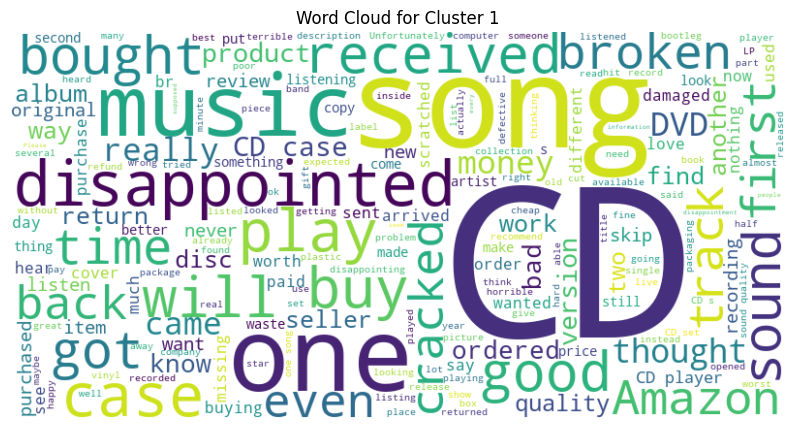

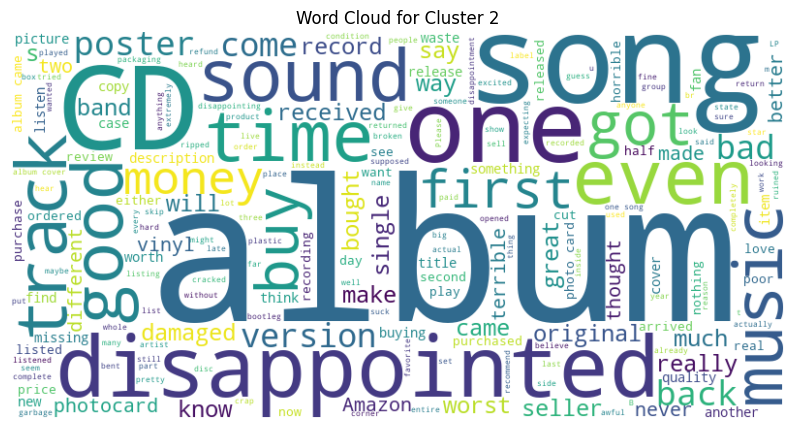

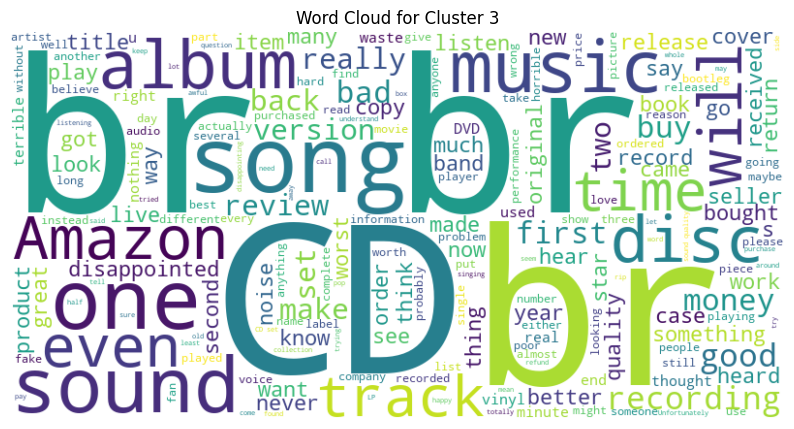

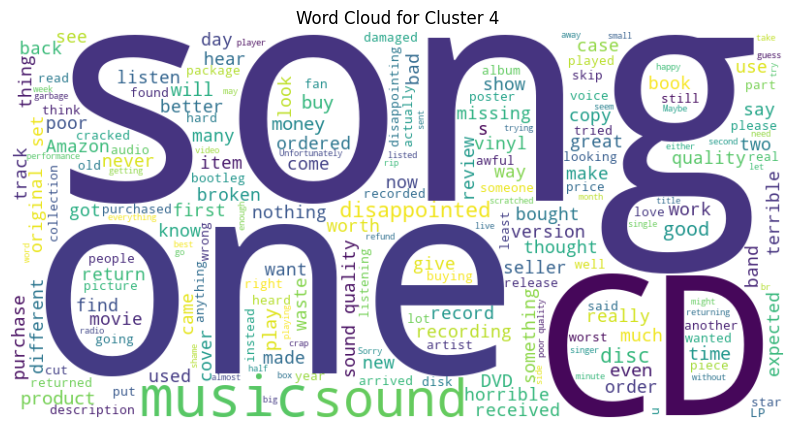

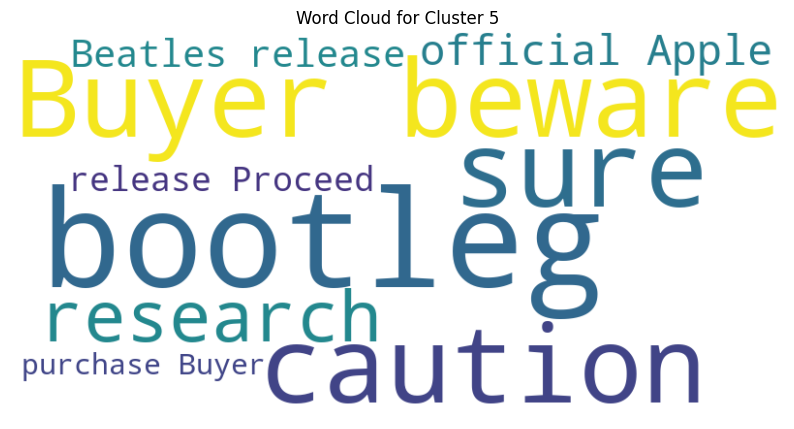

In [19]:
for i in range(num_clusters):
    cluster_reviews = negative_predicted_reviews[negative_predicted_reviews['cluster'] == i]['text']
    text = ' '.join(cluster_reviews)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {i+1}')
    plt.show()
